In [10]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import pandas as pd
from pathlib import Path
import tensorflow_io as tfio
import ast
from pathlib import Path

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

from sklearn.model_selection import train_test_split

**Create Dataset**

In [11]:
SOUND = os.path.join('..', 'Generator', 'audiodata')
SOUND

'..\\Generator_two\\audiodata'

In [12]:
import re 
import glob

txtfiles = []
for file in glob.glob(SOUND+'\*.wav'):
    txtfiles.append(file)
sound = sorted(txtfiles, key=lambda s: int(re.search(r'\d+', s).group()))


In [13]:
release = pd.read_csv('../Generator/audiodata/data.csv')['release'].tolist()

data = list(zip(sound,release))

**Build Preprocessing Function to Convert to RMS**

In [14]:
import librosa

def preprocess(file_path): 
    y, _ = librosa.load(file_path)
    rms = librosa.feature.rms(y=y)[0]
    
    return rms

**Create Training and Testing Partitions**

In [15]:
rms = list()
lables = list()

for file,lable in data:
    rms.append(preprocess(file))
    lables.append(lable)

rms = np.array(rms)
lables = np.array(lables)

In [16]:
train_x, test_x, train_y, test_y = train_test_split(rms, lables, test_size=0.3, random_state=10000)

**Build Model**

In [26]:
model = Sequential()
model.add(Dense(128, input_shape=(173,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [28]:
model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               22272     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 38,913
Trainable params: 38,913
Non-trainable params: 0
_________________________________________________________________


**Train**

In [29]:
hist = model.fit(train_x, train_y, epochs=12, validation_data=(test_x,test_y))

Epoch 1/12
438/438 [==============================] - 2s 2ms/step - loss: 0.0858 - recall_1: 0.3622 - precision_1: 0.9996 - val_loss: 0.0731 - val_recall_1: 0.3357 - val_precision_1: 1.0000
Epoch 2/12
438/438 [==============================] - 1s 2ms/step - loss: 0.0666 - recall_1: 0.3909 - precision_1: 0.9996 - val_loss: 0.0625 - val_recall_1: 0.4023 - val_precision_1: 1.0000
Epoch 3/12
438/438 [==============================] - 1s 2ms/step - loss: 0.0585 - recall_1: 0.4075 - precision_1: 0.9998 - val_loss: 0.0569 - val_recall_1: 0.4765 - val_precision_1: 1.0000
Epoch 4/12
438/438 [==============================] - 1s 2ms/step - loss: 0.0526 - recall_1: 0.4223 - precision_1: 0.9998 - val_loss: 0.0508 - val_recall_1: 0.4498 - val_precision_1: 1.0000
Epoch 5/12
438/438 [==============================] - 1s 2ms/step - loss: 0.0466 - recall_1: 0.4347 - precision_1: 1.0000 - val_loss: 0.0449 - val_recall_1: 0.4372 - val_precision_1: 1.0000
Epoch 6/12
438/438 [==============================

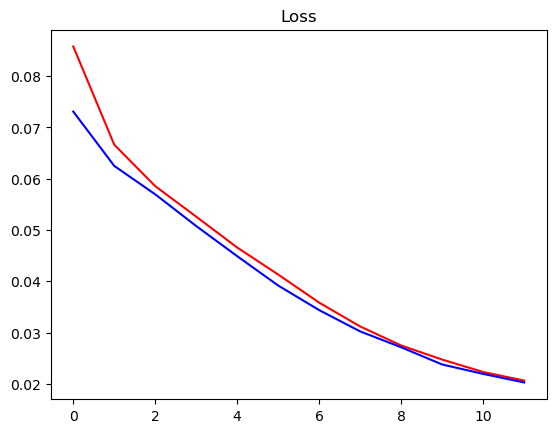

In [30]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

**Test Model with a Single Clip**

In [34]:

test_y

array([0.748, 0.766, 0.145, ..., 0.359, 0.591, 0.554])

In [38]:
yhat = model.predict(test_x)
yhat

188/188 [==============================] - 0s 930us/step


array([[0.7792564],
       [0.7755162],
       [0.1518051],
       ...,
       [0.3624304],
       [0.5632733],
       [0.5218274]], dtype=float32)

In [39]:
score = model.evaluate(test_x,test_y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

188/188 [==============================] - 0s 1ms/step - loss: 0.0203 - recall_1: 0.4870 - precision_1: 1.0000
Test loss: 0.02026952989399433
Test accuracy: 0.4869999885559082
